In [1]:
#!pip install torch
#!pip install pandas
#!pip install matplotlib
#!pip install ipywidgets --user

import pandas as pd
import numpy as np
from torch import nn, optim
import torch
from matplotlib import pyplot as plt

torch.manual_seed(42)

In [2]:
df = pd.read_csv("municipality_bus_utilization.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.round('H').dt.hour
df.head(10)

,timestamp,municipality_id,usage,total_capacity,hour
0,2017-06-04 07:59:42,9,454,1332,8
1,2017-06-04 07:59:42,8,556,2947,8
2,2017-06-04 07:59:42,4,1090,3893,8
3,2017-06-04 07:59:42,0,204,2813,8
4,2017-06-04 07:59:42,7,718,2019,8
5,2017-06-04 07:59:42,5,70,587,8
6,2017-06-04 07:59:42,2,273,697,8
7,2017-06-04 07:59:42,1,129,397,8
8,2017-06-04 07:59:42,6,597,3113,8
9,2017-06-04 07:59:42,3,623,1930,8


In [3]:
hours = [i for i in range(df['hour'].min(), df['hour'].max()+1)]
hours

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [4]:
# missing days
date = df['timestamp'].map(lambda x: x.strftime('%Y-%m-%d'))
missing_dates = pd.date_range('2017-06-04', '2017-08-19').difference(date)
for i in missing_dates:
    print(i)

if missing_dates.shape[0]:
    extended_dates = []
    for m_date in missing_dates:
        for h in hours:
            extended_dates.append(m_date.replace(hour=h))

    extended_mid = [i for i in range(df['municipality_id'].max()+1)] * len(extended_dates)
    extended_dates = sorted(extended_dates*10)
    extended_usage = [np.nan] * len(extended_mid)
    extended_df = pd.DataFrame(data={'timestamp': extended_dates, 
                                    'municipality_id': extended_mid, 
                                    'usage': extended_usage})

    df = pd.concat((df, extended_df), ignore_index = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = df['timestamp'].dt.round('H')

2017-06-20 00:00:00
2017-06-21 00:00:00
2017-07-31 00:00:00
2017-08-03 00:00:00
2017-08-04 00:00:00


In [5]:
# missing hours
hours = df['timestamp'].map(lambda x: x.strftime('%H:%M:%S'))
missing_hours = pd.date_range('8:00:00', '17:00:00').difference(hours)

if missing_hours.shape[0]:
    extended_hours = []
    for m_hour in missing_hours:
        extended_hours.append(m_hour)

    extended_mid = [i for i in range(df['municipality_id'].max()+1)] * len(extended_hours)
    extended_hours = sorted(extended_hours*10)
    extended_usage = [np.nan] * len(extended_mid)
    extended_df = pd.DataFrame(data={'timestamp': extended_hours, 
                                     'municipality_id': extended_mid, 
                                     'usage': extended_usage})
    df = df.append(extended_df, ignore_index = True)


In [6]:
# interpolate
for i in range(df['municipality_id'].max()+1):
    tmp = df.loc[df['municipality_id'] == i].copy()
    tmp['usage'] = tmp['usage'].interpolate(method="linear")
    df.loc[df['municipality_id'] == i] = tmp

In [7]:
# remove duplicates and get the maximum usage
df = df.sort_values(['timestamp', 'municipality_id', 'usage']).drop_duplicates(['timestamp', 'municipality_id'], keep='last')

In [8]:
train_data = df[df['timestamp'] < '2017-08-05']
test_data = df[df['timestamp'] >= '2017-08-05']
print(train_data.shape)
print(test_data.shape)

(5950, 5)
(1420, 5)


In [9]:
def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out


class LSTM(nn.Module):
    
    def __init__(self, input_size=1, num_layers=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=input_size, num_layers=num_layers, hidden_size=hidden_size)
        
        self.linear = nn.Linear(hidden_size, out_size)

        self.hidden = (torch.zeros(self.num_layers, 1, hidden_size), torch.zeros(self.num_layers, 1, hidden_size))
    
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(1, len(seq), -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[-1]

Municipality 0
Epoch 25 | MSE Loss: 0.33184188741401327
Epoch 50 | MSE Loss: 0.33110832073502383
Epoch 75 | MSE Loss: 0.33079852243325025
Epoch 100 | MSE Loss: 0.33057243698042804
Municipality 1
Epoch 25 | MSE Loss: 0.596271529578805
Epoch 50 | MSE Loss: 0.5794194571031502
Epoch 75 | MSE Loss: 0.5756107815851275
Epoch 100 | MSE Loss: 0.575008300876246
Municipality 2
Epoch 25 | MSE Loss: 0.4080203727249936
Epoch 50 | MSE Loss: 0.40514921081854643
Epoch 75 | MSE Loss: 0.40347684017788105
Epoch 100 | MSE Loss: 0.4022706205871133
Municipality 3
Epoch 25 | MSE Loss: 0.3457516003154614
Epoch 50 | MSE Loss: 0.33719737396974375
Epoch 75 | MSE Loss: 0.3345287586585515
Epoch 100 | MSE Loss: 0.3329824768679701
Municipality 4
Epoch 25 | MSE Loss: 0.34254120563783663
Epoch 50 | MSE Loss: 0.32685908871468294
Epoch 75 | MSE Loss: 0.32407144836033575
Epoch 100 | MSE Loss: 0.32333977364455174
Municipality 5
Epoch 25 | MSE Loss: 0.3325522855653471
Epoch 50 | MSE Loss: 0.3322388221497091
Epoch 75 | MSE L

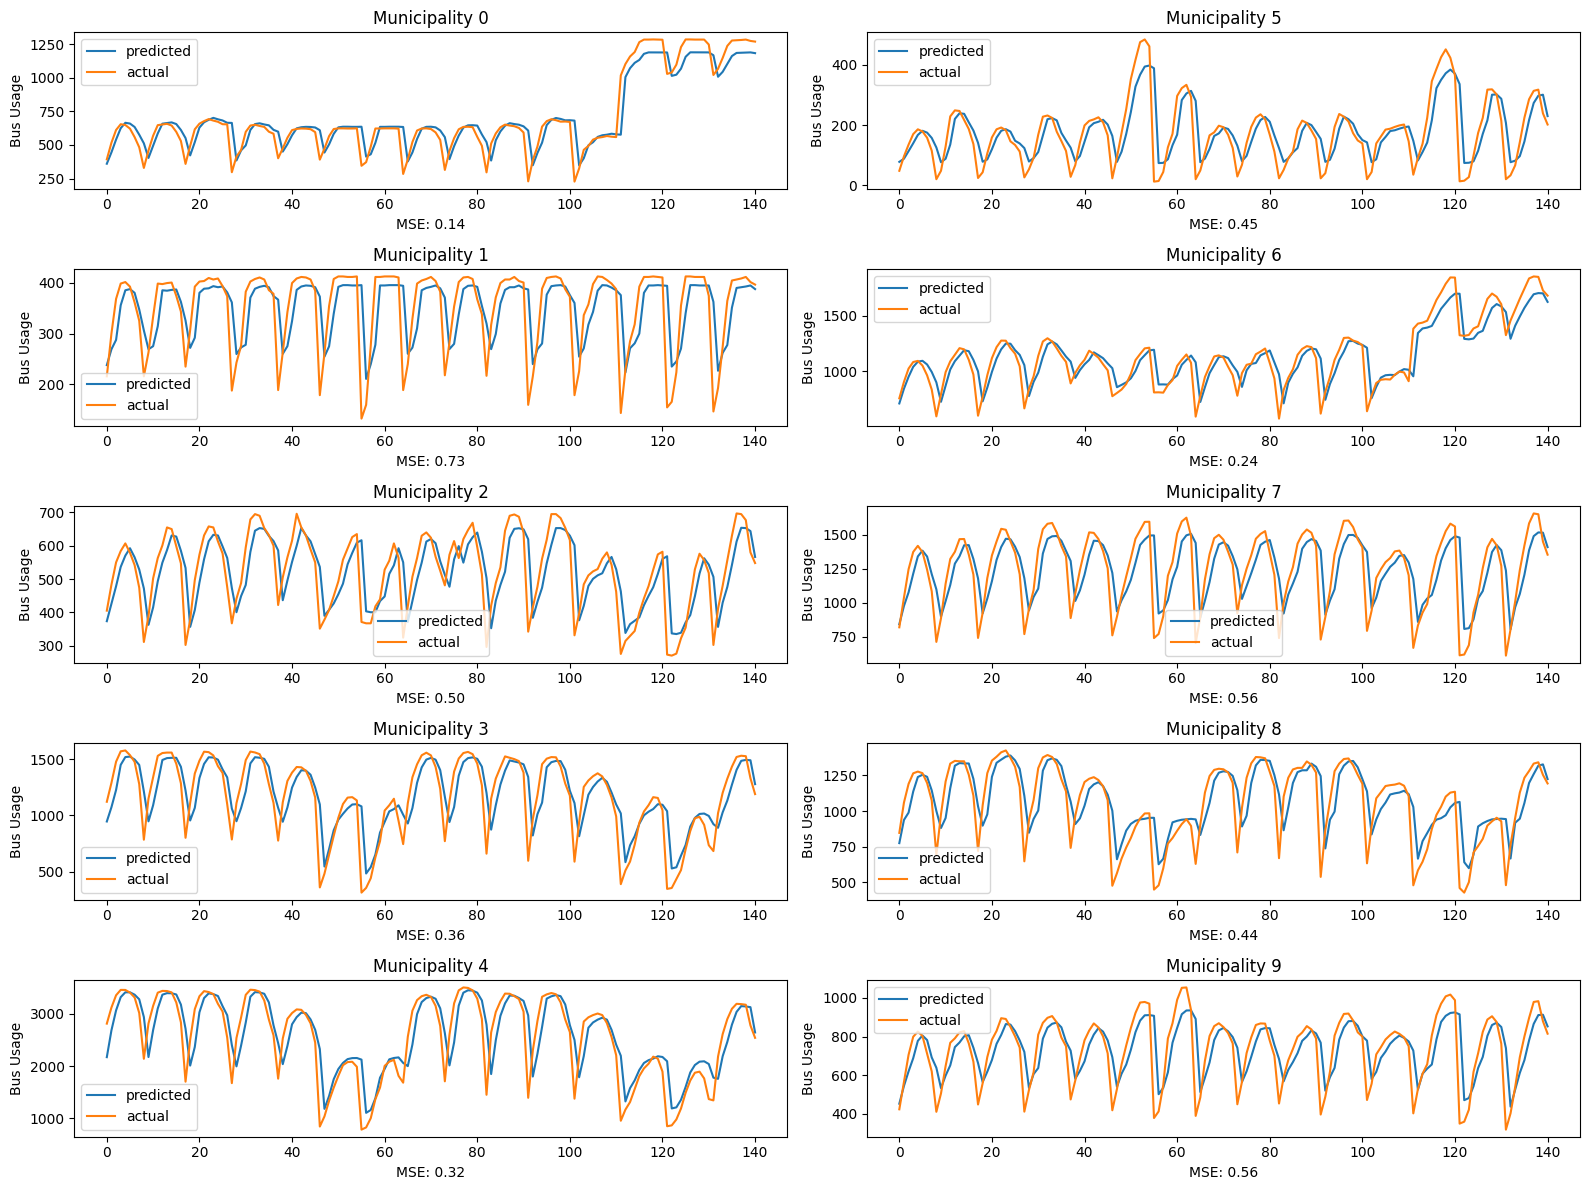

In [10]:
fig, ax = plt.subplots(5, 2, figsize=(16, 12))
for i in range(df['municipality_id'].max()+1):
    print(f'Municipality {i}')
    m0_train = train_data[train_data['municipality_id'] == i]
    m0_test = test_data[test_data['municipality_id'] == i]

    m0_train = m0_train['usage'].to_numpy(dtype=np.float32)

    m0_test = m0_test['usage'].to_numpy(dtype=np.float32)

    mean = np.mean(m0_train)
    std = np.std(m0_test)

    window_size = 1
    m0_train = input_data(m0_train, window_size)
    m0_test = input_data(m0_test, window_size)


    num_layers = 1
    input_size = 1
    model = LSTM(input_size=input_size, num_layers=num_layers, hidden_size=10, out_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 100

    for e in range(1, epochs+1):
        total_loss = 0.0
        for seq, y_train in m0_train:
            optimizer.zero_grad()
            model.hidden = (torch.zeros(num_layers,window_size,model.hidden_size),
                        torch.zeros(num_layers,window_size,model.hidden_size))

            seq = torch.from_numpy(seq)
            y_train = torch.from_numpy(y_train) 

            seq = (seq - mean) / std
            y_train = (y_train - mean) / std

            y_pred = model(seq)
            
            loss = criterion(y_pred, y_train)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        if e % 25 == 0:
            print(f"Epoch {e} | MSE Loss: {total_loss / len(m0_train)}")

    total_loss = 0.0
    results = []
    for seq, y_test in m0_test:
        with torch.no_grad():
            model.hidden = (torch.zeros(num_layers,window_size,model.hidden_size),
                            torch.zeros(num_layers,window_size,model.hidden_size))
            seq = torch.from_numpy(seq)
            y_test = torch.from_numpy(y_test) 

            seq = (seq - mean) / std
            y_test = (y_test - mean) / std

            pred = model(seq)
            loss = criterion(pred, y_test)
            total_loss += loss.item()

            pred = (pred * std) + mean
            y_test = (y_test * std) + mean
            
            pred = pred.cpu().detach().numpy()
            y_test = y_test.cpu().detach().numpy()
            results.append([pred, y_test])

    total_loss = total_loss / len(m0_test)
    results = np.asarray(results)

    fj = int(i / 5)
    fi = int(i % 5)
    # plotting
    pred = (pred * std) + mean
    ax[fi][fj].plot(results[:, 0], label='predicted')
    ax[fi][fj].plot(results[:, 1], label='actual')
    ax[fi][fj].set_title(f'Municipality {i}')
    ax[fi][fj].set_ylabel('Bus Usage')
    ax[fi][fj].set_xlabel('MSE: {:.2f}'.format(total_loss))
    ax[fi][fj].legend()
plt.tight_layout()
plt.show()